This notebook calculates spectral indices, develops a thresholded flood map and calculates the accuracy score relative to a reference data set for the Koumassi area of interest. 

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
from glob import glob
import pickle
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Import modules with custom functions
import sys
sys.path.insert(0, '..\\modules\\')
import morph_indices
import calc_array_mask

### Note: user should update "aoi" parameter with directory name for imagery of interest

In [3]:
# Identify area of interest (aoi), set directories for inputs and outputs
aoi = "koumassi_focus_ps"

# Check for existing imagery directory
band_path = '..\\data\\'+aoi+"\\"
try:
    os.makedirs(band_path)
except FileExistsError:
    print("band_path directory already exists!")

# Check for existing outputs directory for raster files
outputs_path = os.path.join(band_path, "final_outputs\\raster_files\\")
try:
    os.makedirs(outputs_path)
except FileExistsError:
    print("outputs_path directory already exists!")
threshold_outputs_path = os.path.join(band_path, "final_outputs\\threshold\\")
try:
    os.makedirs(threshold_outputs_path)
except FileExistsError:
    print("threshold_outputs_path directory already exists!")

# Set path for validation data
validation_data_path = os.path.join(band_path, 'validation\\')

# Imports validation data
sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\additional_val_points_koumassi.shp")
valid_data = pd.read_csv(validation_data_path +
                         "additional_val_points_koumassi.csv")

band_path directory already exists!
outputs_path directory already exists!
threshold_outputs_path directory already exists!


In [4]:
# Create raster stack of all spectral bands
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                     all_bands_path)

In [5]:
# Open raster stack and make copies of meta file for use in writing out files later
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
    masks_out_meta = src.meta.copy()

In [6]:
# Update files_out_meta for writing out single files
files_out_meta['count'] = 1

# Update masks_out_meta for writing single integer type files
masks_out_meta['dtype'] = 'int32'
masks_out_meta['count'] = 1

In [7]:
# Scale raster stack to surface reflectance values (should be between 0 and 1)
all_bands_scaled = all_bands_stack/10000

In [8]:
# Read in scaled bands
coastal_scaled = all_bands_scaled[0]
blue_scaled = all_bands_scaled[1]
green_scaled = all_bands_scaled[2]
yellow_scaled = all_bands_scaled[3]
red_scaled = all_bands_scaled[4]
rededge_scaled = all_bands_scaled[5]
nearir1_scaled = all_bands_scaled[6]
nearir2_scaled = all_bands_scaled[7]

# Calculate NDWI, NDVI and DARK parameters

In [9]:
# Calculate NDWI, NDVI and dark parameters
ndwi0 = es.normalized_diff(b1=green_scaled, b2=nearir1_scaled)
ndwi0_v2 = es.normalized_diff(b1=green_scaled, b2=nearir2_scaled)
ndwi1 = es.normalized_diff(b1=coastal_scaled, b2=nearir2_scaled)
ndwi2 = es.normalized_diff(b1=yellow_scaled, b2=nearir2_scaled)
ndvi = es.normalized_diff(b1=nearir1_scaled, b2=red_scaled)
dark = rededge_scaled + nearir1_scaled + nearir2_scaled

In [10]:
# Write out files
with rio.open(outputs_path+'ndvi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndvi, 1)
with rio.open(outputs_path+'dark.tif', 'w', **files_out_meta) as dst:
    dst.write(dark, 1)

# Write out NDVI and dark parameters, tagged with "raw" for inclusion in SVM model
with rio.open(outputs_path+'raw_ndvi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndvi, 1)
with rio.open(outputs_path+'raw_dark.tif', 'w', **files_out_meta) as dst:
    dst.write(dark, 1)

In [11]:
# Calculate and compare mean NDWI values
mean_ndwi0 = np.nanmean(ndwi0)
mean_ndwi0_v2 = np.nanmean(ndwi0_v2)
mean_ndwi1 = np.nanmean(ndwi1)
mean_ndwi2 = np.nanmean(ndwi2)
print("NDWI0:", mean_ndwi0, "NDWI0_v2", mean_ndwi0_v2,
      "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0: -0.09864223 NDWI0_v2 -0.07030483 NDWI1: -0.15147693 NDWI2: -0.02483559


### Thresholds for plotting can be changed based on user preference

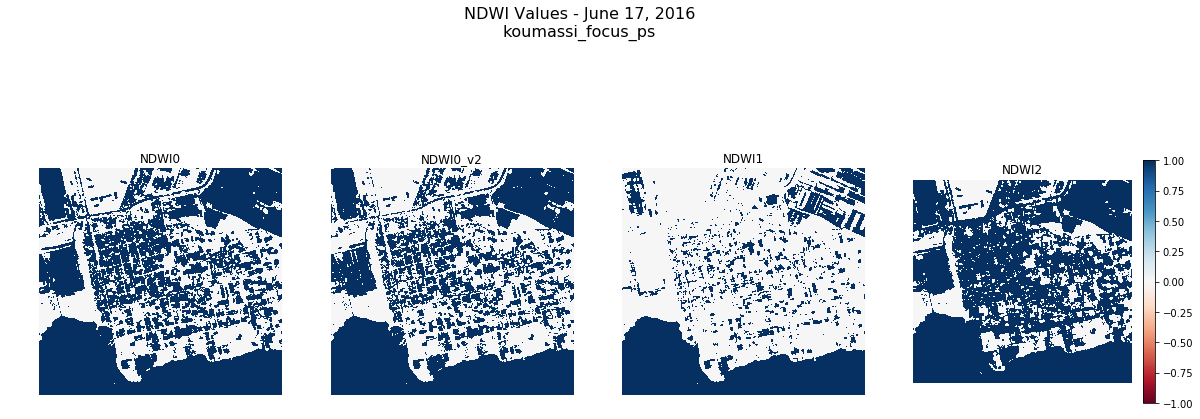

In [12]:
# Plot NDWIs for comparison
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
# was at -0.20
threshold = -0.15
plt.suptitle('NDWI Values - June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi0_plot = ax1.imshow(ndwi0 > threshold, cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(ndwi0_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi0_v2_plot = ax2.imshow(ndwi0_v2 > threshold, cmap='RdBu', vmin=-1, vmax=1)
ax2.set(title="NDWI0_v2")
ax2.set_axis_off()

ndwi1_plot = ax3.imshow(ndwi1 > threshold, cmap='RdBu', vmin=-1, vmax=1)
ax3.set(title="NDWI1")
ax3.set_axis_off()

ndwi2_plot = ax4.imshow(ndwi2 > threshold, cmap='RdBu', vmin=-1, vmax=1)
ax4.set(title="NDWI2")
ax4.set_axis_off()

### The threshold values for each flood mask can be changed per user preference

In [13]:
# Calculate parameters to mimic Cloud to Street algorithm
flood1 = ((ndwi1 >= -0.30) & (dark <= 2) & (coastal_scaled <= 0.5)
          & (red_scaled <= 0.5)).astype(int)
flood2 = ((ndwi2 >= -0.12) & (dark <= 2) & (coastal_scaled <= 0.5)).astype(int)

# Combine flood1 and flood 2
flood_combo = np.ma.where(flood1 == 1, 1, np.where(flood2 == 1, 1, 0))

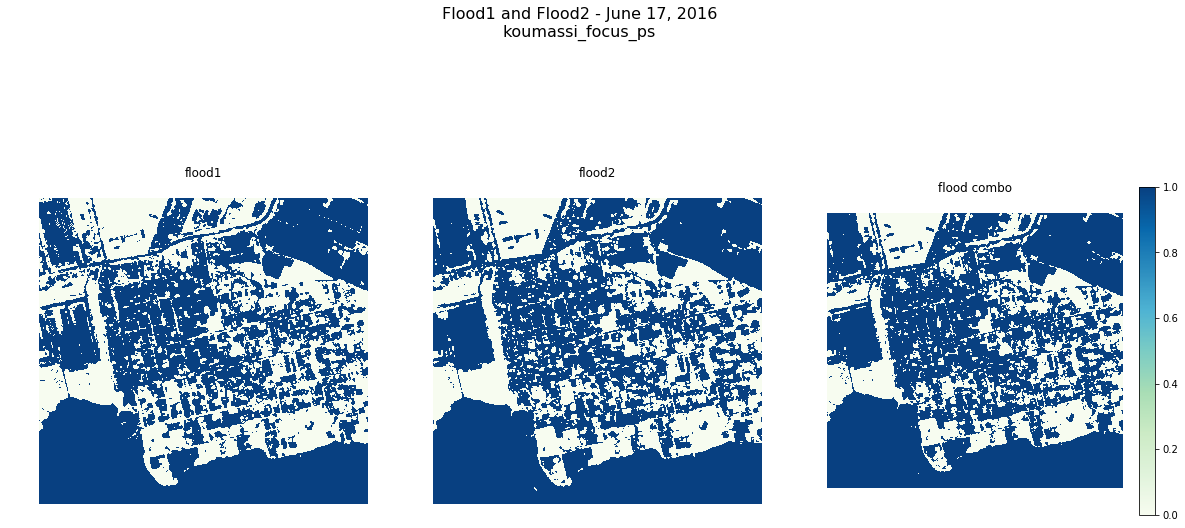

In [14]:
# Plot Flood1, Flood2 and Flood Combo masks
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
plt.suptitle('Flood1 and Flood2 - June 17, 2016\n'+aoi+"\n", fontsize=16)

flood1_plot = ax1.imshow(flood1, cmap='GnBu', vmin=0, vmax=1)
fig.colorbar(flood1_plot, fraction=.05)
ax1.set(title="flood1\n")
ax1.set_axis_off()

flood2_plot = ax2.imshow(flood2, cmap='GnBu', vmin=0, vmax=1)
ax2.set(title="flood2\n")
ax2.set_axis_off()

flood_combo_plot = ax3.imshow(flood_combo, cmap='GnBu', vmin=0, vmax=1)
ax3.set(title="flood combo\n")
ax3.set_axis_off()

### The threshold values for each NDWI mask can be changed per user preferences

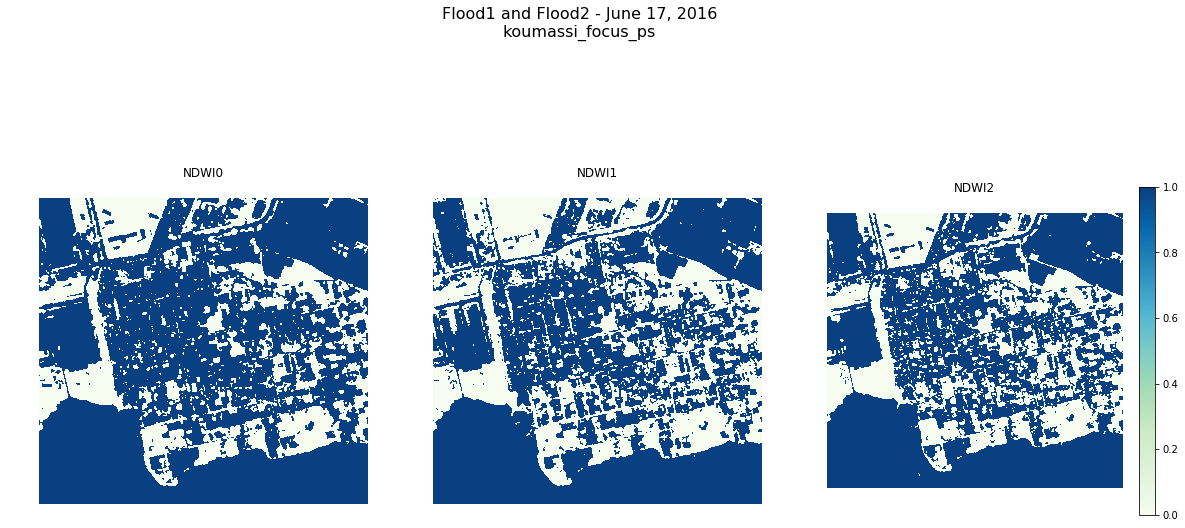

In [15]:
# Plot NDWI masks
ndwi0_thresh = -0.20
ndwi1_thresh = -0.30
ndwi2_thresh = -0.12

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
plt.suptitle('Flood1 and Flood2 - June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi0_plot = ax1.imshow(ndwi0 > ndwi0_thresh, cmap='GnBu', vmin=0, vmax=1)
fig.colorbar(ndwi0_plot, fraction=.05)
ax1.set(title="NDWI0\n")
ax1.set_axis_off()

ndwi1_plot = ax2.imshow(ndwi1 > ndwi1_thresh, cmap='GnBu', vmin=0, vmax=1)
ax2.set(title="NDWI1\n")
ax2.set_axis_off()

ndwi2_plot = ax3.imshow(ndwi2 > ndwi2_thresh, cmap='GnBu', vmin=0, vmax=1)
ax3.set(title="NDWI2\n")
ax3.set_axis_off()

### User can make choices on threshold and disk_size for morphological smoothing

In [16]:
# Apply morphological opening to reduce noise for flood combo
flood_mask = morph_indices.smooth_disk(
    index_array=flood_combo, threshold=0.1, disk_size=1)

# Define vegetation mask
vegetation_mask = morph_indices.smooth_disk(
    index_array=ndvi, threshold=0.1, disk_size=0)

In [17]:
# Write out flood mask files
with rio.open(outputs_path+'flood1_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood1, 1)
with rio.open(outputs_path+'flood2_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood2, 1)
with rio.open(outputs_path+'flood_combo_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood_mask, 1)

# Write out vegetation mask file
with rio.open(outputs_path+'vegetation_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(vegetation_mask, 1)

# Write out mask files based on thresholds
with rio.open(outputs_path+'ndwi0_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi0 > -0.12).astype(int), 1)
with rio.open(outputs_path+'ndwi1_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi1 > -0.12).astype(int), 1)
with rio.open(outputs_path+'ndwi2_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi2 > -0.12).astype(int), 1)

# Calculate Morphological Shadow Index (MSI)

### User can change s_min, s_max and s_delta. Current parameters chosen based on Huang et al. (2012)

In [18]:
# Calculate MSI
msi = morph_indices.calc_msi(
    raster_input=all_bands_scaled, s_min=2, s_max=52, s_delta=5)

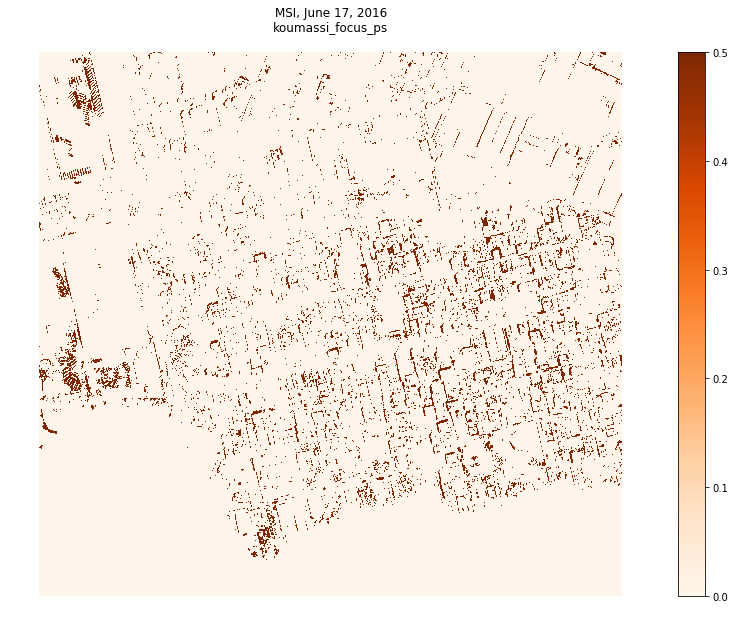

In [19]:
# Plot MSI
fig, ax = plt.subplots(figsize=(20, 10))
msi_plot = ax.imshow(msi >= 0.12, cmap='Oranges',
                     vmin=0, vmax=0.5)
fig.colorbar(msi_plot, fraction=0.05)
ax.set(title="MSI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

### Threshold and disk size can be changed based on user preference 

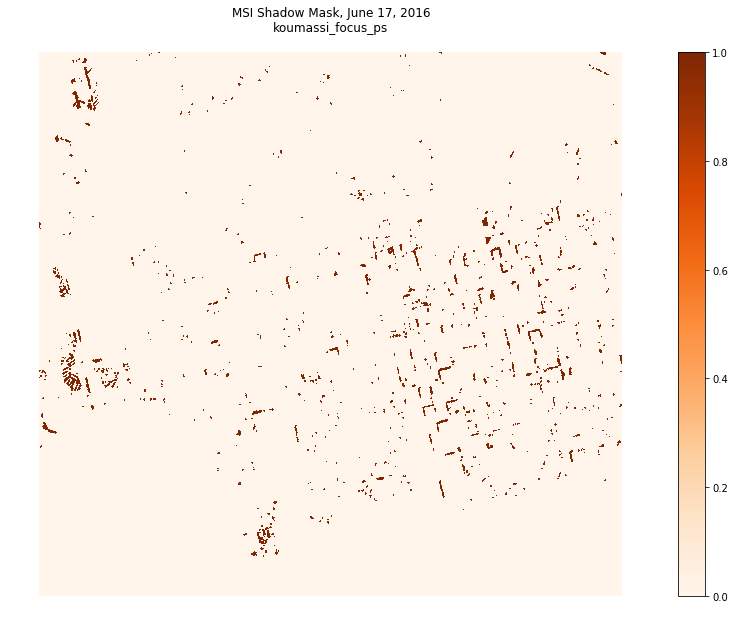

In [20]:
# Develop shadow mask from MSI by applying morphological smoothing.
# Note that threshold and disk size may be varied.
shadow_mask = morph_indices.smooth_disk(
    index_array=msi, threshold=0.12, disk_size=2)

# Plot shadow mask
fig, ax = plt.subplots(figsize=(20, 10))
test_plot = ax.imshow(shadow_mask, cmap='Oranges')
fig.colorbar(test_plot, fraction=.05)
ax.set(title="MSI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [21]:
# Write out MSI and shadow mask tif file
with rio.open(outputs_path+'shadow_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(shadow_mask, 1)
with rio.open(outputs_path+'msi'+'.tif', 'w', **files_out_meta) as dst:
    dst.write(msi, 1)

# Write out MSI tagged with 'raw' for inclusion in SVM model inputs
with rio.open(outputs_path+'raw_msi'+'.tif', 'w', **files_out_meta) as dst:
    dst.write(msi, 1)

# Calculate NDWI "optimal" - MSI from Xie et al (2016)

In [22]:
# Calculate optimal NDWI values with NIR2
ndwi_coastal = es.normalized_diff(b1=coastal_scaled, b2=nearir2_scaled)

# Note that ndwi_yellow is same as ndwi2 above
ndwi_yellow = es.normalized_diff(b1=yellow_scaled, b2=nearir2_scaled)

In [23]:
# Substract MSI from most promising NDWI results
ndwi_coastal_msi = ndwi_coastal - msi
ndwi_yellow_msi = ndwi_yellow - msi

### Threshold can be changed based on user preference 

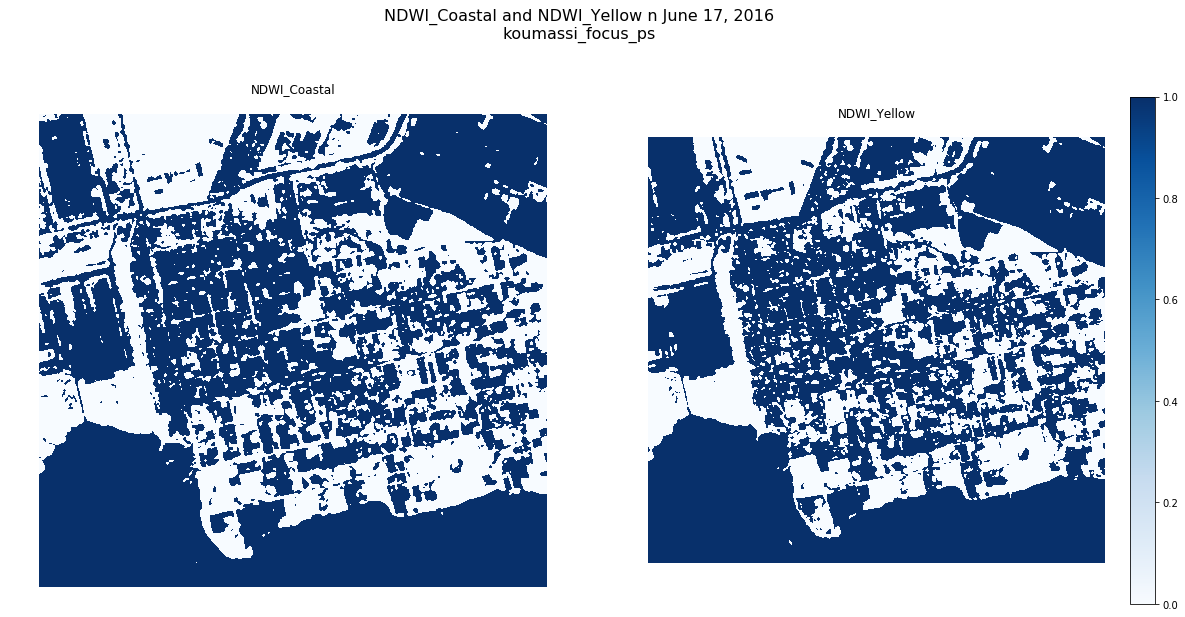

In [24]:
# Plots for NDWI_Coastal  and NDWI_Yellow Masks
thresh = -0.12
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Coastal and NDWI_Yellow n June 17, 2016\n' +
             aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(
    ndwi_coastal > -.30, cmap='Blues', vmin=0, vmax=1)
ax1.set(title="NDWI_Coastal\n")
ax1.set_axis_off()

ndwi_yellow_plot = ax2.imshow(
    ndwi_yellow > thresh, cmap='Blues', vmin=0, vmax=1)
ax2.set(title="NDWI_Yellow\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

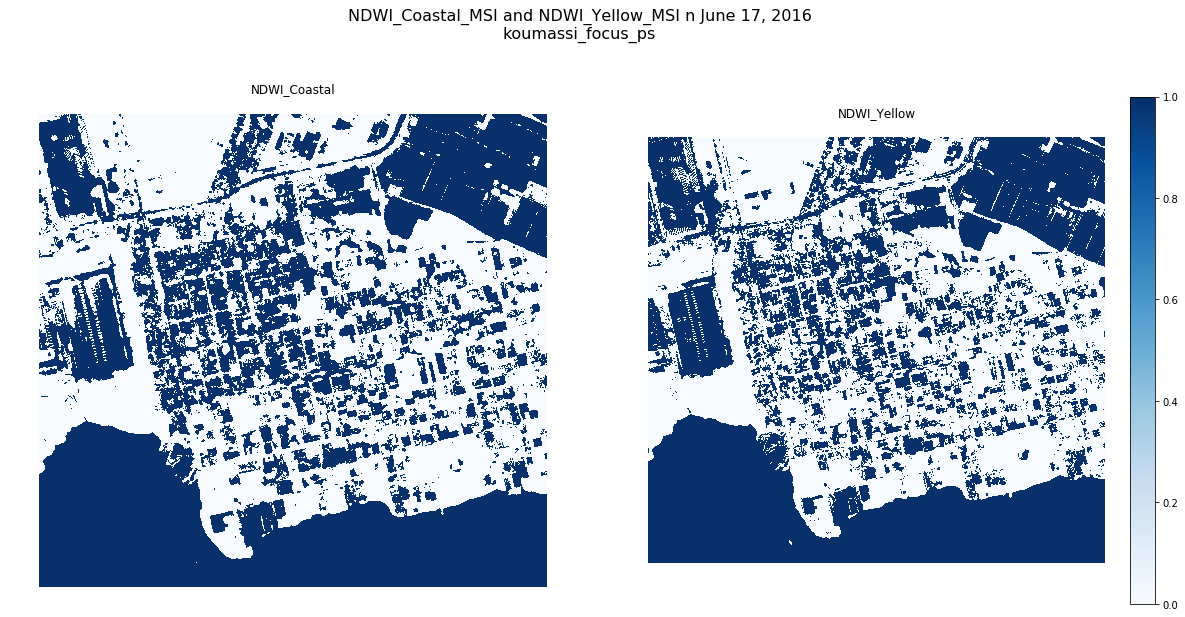

In [25]:
# Plots for NDWI_Coastal  and NDWI_Yellow Masks
thresh = -0.12
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle(
    'NDWI_Coastal_MSI and NDWI_Yellow_MSI n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(
    ndwi_coastal_msi > -.30, cmap='Blues', vmin=0, vmax=1)
ax1.set(title="NDWI_Coastal\n")
ax1.set_axis_off()

ndwi_yellow_plot = ax2.imshow(
    ndwi_yellow_msi > thresh, cmap='Blues', vmin=0, vmax=1)
ax2.set(title="NDWI_Yellow\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

In [26]:
# Write out files tagged with 'raw' for inclusion in SVM model inputs
with rio.open(outputs_path+'raw_ndwi_coastal.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_coastal, 1)
with rio.open(outputs_path+'raw_ndwi_coastal_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_coastal_msi, 1)
with rio.open(outputs_path+'raw_ndwi_yellow.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_yellow, 1)
with rio.open(outputs_path+'raw_ndwi_yellow_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_yellow_msi, 1)

# Calculate Morphological Building Index (MBI)

### User can change s_min, s_max and s_delta. Current parameters chosen based on Huang et al. (2012)

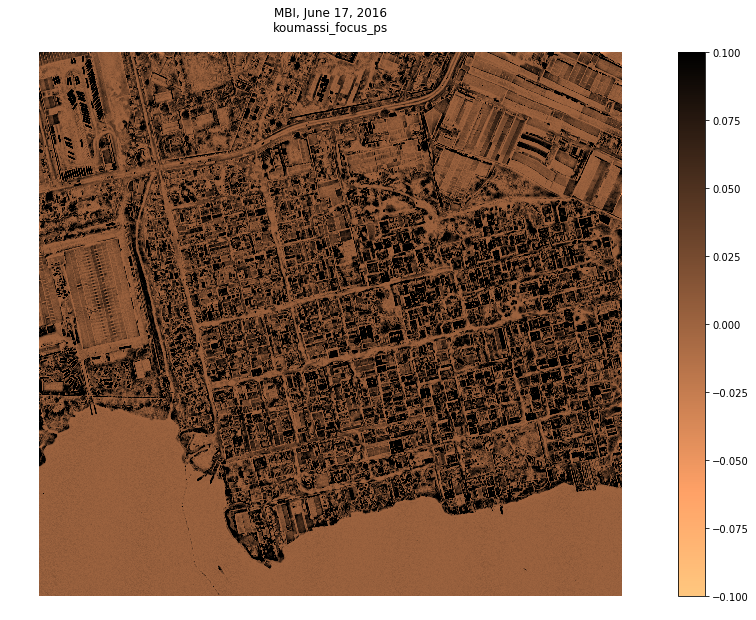

In [27]:
# Calculate MBI
mbi = morph_indices.calc_mbi(
    raster_input=all_bands_scaled, s_min=2, s_max=52, s_delta=5)

# Plot MBI
fig, ax = plt.subplots(figsize=(20, 10))
mbi_plot = ax.imshow(mbi, cmap='copper_r',
                     vmin=0, vmax=0)
fig.colorbar(mbi_plot, fraction=0.05)
ax.set(title="MBI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

### Threshold and disk size can be changed based on user preference 

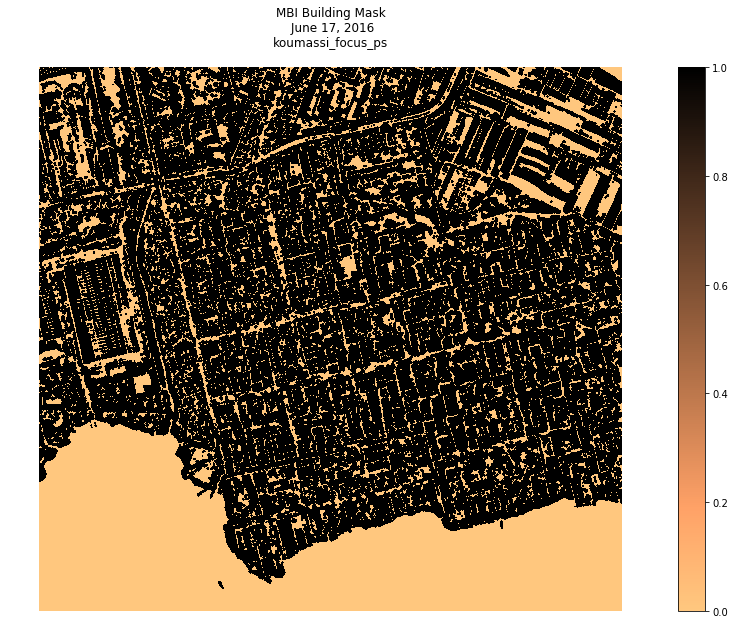

In [28]:
# Develop shadow mask for MBI >=0.025 and apply morphological opening
# Previous threshold = 0.015
building_mask = morph_indices.smooth_disk(
    index_array=mbi, threshold=0.005, disk_size=3)

# Plot building mask layer
fig, ax = plt.subplots(figsize=(20, 10))
building_plot = ax.imshow(building_mask, cmap='copper_r',
                          vmin=0, vmax=1)
fig.colorbar(building_plot, fraction=.05)
ax.set(title="MBI Building Mask\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [29]:
# Write out MBI and building mask files
with rio.open(outputs_path+'building_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(building_mask, 1)
with rio.open(outputs_path+'mbi.tif', 'w', **files_out_meta) as dst:
    dst.write(mbi, 1)

# Write out MBI tagged with 'raw' for inclusion in SVM model inputs
with rio.open(outputs_path+'raw_mbi.tif', 'w', **files_out_meta) as dst:
    dst.write(mbi, 1)

# Combine land cover type masks into single image
Hierarchy is as follows: Shadow_mask, flood_mask, veg_mask, building_mask

Which means:
- values of 5, 10, 15, 20, 30, 60, 120 --> 5 (shadow)
- values of 4, 8, 24 --> 4 (water) 
- values of 3, 6 --> 3 (vegetation)
- values of 2,12 --> 2 (building) **Exception for hierarchy so buildings "overrule" flood*

In [30]:
# Combining masks into single array
shadow_mask_comb = shadow_mask*5
flood_mask_comb = flood_mask*4
veg_mask_comb = vegetation_mask*3
building_mask_comb = building_mask*2
index_comb = shadow_mask_comb*flood_mask_comb*veg_mask_comb*building_mask_comb

shadow_mask_comb = np.where(shadow_mask_comb == 0, 1, shadow_mask_comb)
flood_mask_comb = np.ma.where(flood_mask_comb == 0, 1, flood_mask_comb)
veg_mask_comb = np.where(veg_mask_comb == 0, 1, veg_mask_comb)
building_mask_comb = np.where(building_mask_comb == 0, 1, building_mask_comb)
index_comb = shadow_mask_comb*flood_mask_comb*veg_mask_comb*building_mask_comb
np.unique(index_comb)

# Reassign multiplied values to each defined class
index_comb = np.where(index_comb >= 30, 5, index_comb)
index_comb = np.where(index_comb == 10, 5, index_comb)
index_comb = np.where(index_comb == 15, 5, index_comb)
index_comb = np.where(index_comb == 20, 5, index_comb)
index_comb = np.where(index_comb == 24, 4, index_comb)
index_comb = np.where(index_comb == 12, 4, index_comb)
index_comb = np.where(index_comb == 8, 2, index_comb)
index_comb = np.where(index_comb == 6, 3, index_comb)

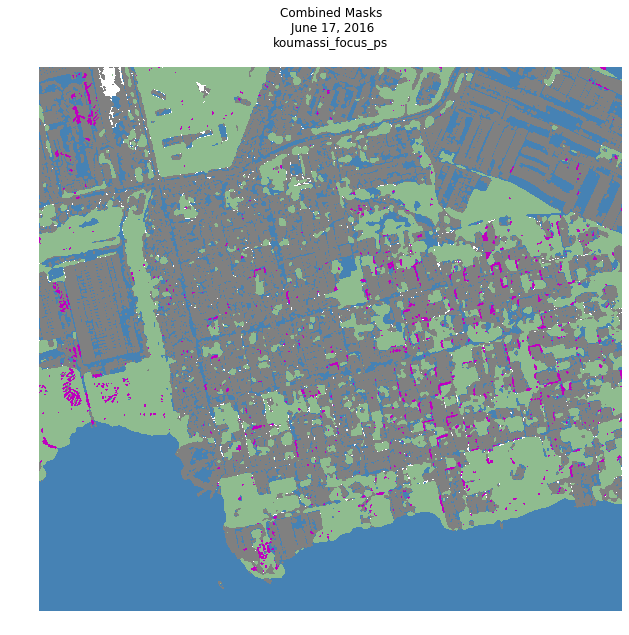

In [31]:
# Plot combined masks
fig, ax = plt.subplots(figsize=(20, 10))
cmap = ListedColormap(['white', 'grey', 'darkseagreen', 'steelblue', 'm'])
ax.imshow(index_comb, cmap=cmap)
ax.set(title="Combined Masks\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

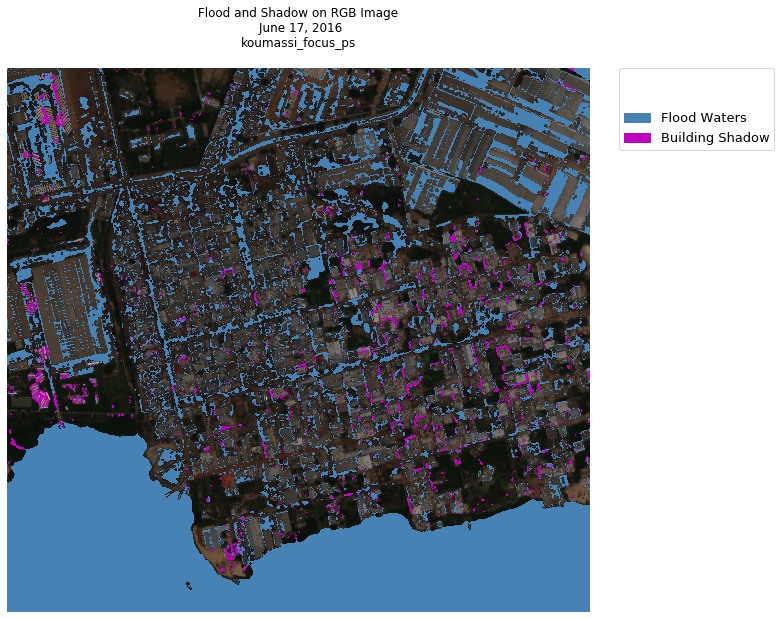

In [32]:
# Make RGB-stack for plotting with threshold results
rgb_bands = glob(band_path+"*band_[1,2,4]*")
rgb_bands.sort()
rgb_bands_path = os.path.join(threshold_outputs_path, aoi + "_rgb_bands.tif")
rgb_bands, rgb_bands_meta = es.stack(rgb_bands,
                                     rgb_bands_path)

# Plot flood and shadow masks over RGB image
fig, ax = plt.subplots(figsize=(20, 10))
ep.plot_rgb(rgb_bands, rgb=(2, 1, 0), ax=ax)
cmap = ListedColormap(['none', 'none', 'none', 'steelblue', 'm'])
im = ax.imshow(index_comb, cmap=cmap)
ep.draw_legend(im, titles=['', '', 'Flood Waters',
                           'Building Shadow'], classes=[1, 2, 3, 4])
ax.set(title="Flood and Shadow on RGB Image\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

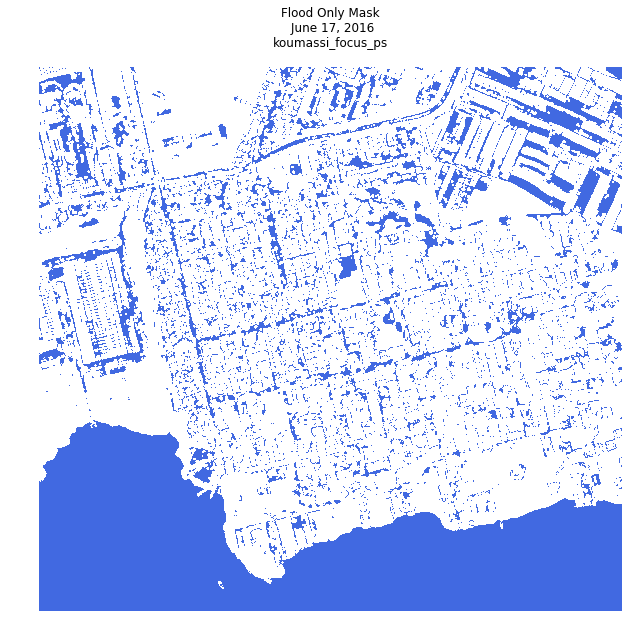

In [33]:
# Subset flood mask on its own
flood_only_index_comb = np.where(index_comb != 4, 0, index_comb)

# Plot flood only mask
fig, ax = plt.subplots(figsize=(20, 10))
cmap = ListedColormap(['none', 'royalblue'])
ax.imshow(flood_only_index_comb, cmap=cmap)
ax.set(title="Flood Only Mask\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [34]:
# Write out threshold maps
with rio.open(threshold_outputs_path+'koumassi_threshold_map.tif', 'w', **files_out_meta) as dst:
    dst.write(index_comb.astype('float32'), 1)
with rio.open(threshold_outputs_path+'_koumassi_flood_only_index_comb.tif', 'w', **files_out_meta) as dst:
    dst.write(flood_only_index_comb.astype('float32'), 1)

# Validate model with reference data set

In [35]:
# Sample reference points
# Create tuples of all x coordinates and y coordinates
x_coords = tuple(sample_pts.geometry.x)
y_coords = tuple(sample_pts.geometry.y)

index_comb_path = threshold_outputs_path+"koumassi_threshold_map.tif"
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(index_comb_path) as src:
    for val in src.sample(zip(x_coords, y_coords)):

        # Note that each val is an individual numpy array
        sampled_values.append(val)

# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()

# Convert array to dataframe
index_comb_df = pd.DataFrame(arr)
index_comb_df.head()
index_comb_df.columns = ["Land_Cover_Class"]

# Combine reference data with index values
accuracy_threshold = pd.concat([valid_data, index_comb_df], axis=1, sort=False)
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class']
                       == 5.0, "Threshold_ClassValue"] = 1
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class']
                       == 4.0, "Threshold_ClassValue"] = 2
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class']
                       == 3.0, "Threshold_ClassValue"] = 3
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class']
                       == 2.0, "Threshold_ClassValue"] = 4
accuracy_threshold.loc[accuracy_threshold['Land_Cover_Class']
                       == 1.0, "Threshold_ClassValue"] = 5  # No data

In [36]:
# Calculate accuracy score
ytest = accuracy_threshold['ClassValue']
ypred = accuracy_threshold['Threshold_ClassValue']
accuracy_score(ytest, ypred)

0.674246430460074

[[203 276  59   6]
 [ 41 284  51  46]
 [  0   1 413   0]
 [  1  92  21 375]]


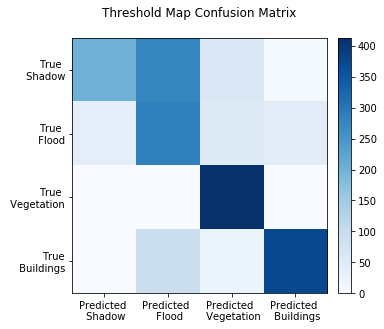

In [37]:
# Print confusion matrix
conf_matrix = confusion_matrix(ytest, ypred)
conf_matrix = conf_matrix[0:4, 0:4]
print(conf_matrix)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 
                                               'Predicted \n Flood', 
                                               'Predicted \n Vegetation', 
                                               'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 
                                           'True \n Flood', 
                                           'True \n Vegetation', 
                                           'True\n Buildings'])
conf_mat = ax.imshow(conf_matrix, cmap='Blues',
                     interpolation='nearest')
ax.set(title="Threshold Map Confusion Matrix\n")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
plt.show()

In [38]:
# Write out confusion matrix
confusion_threshold = confusion_matrix(ytest, ypred)
pd.DataFrame(confusion_threshold).to_csv(
    threshold_outputs_path+'koumassi_threshold_confusion.csv')

0.668235294117647

[[  0   0   0   0]
 [ 41 284  51  46]
 [  0   0   0   0]
 [  0   0   0   0]]


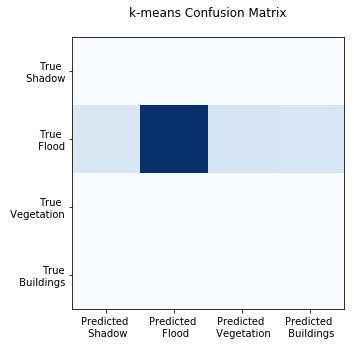

In [39]:
# Subset to focus only on flood, all other reference points (shadow, other) removed
flood_only_accuracy = accuracy_threshold[accuracy_threshold.ClassValue == 2]

# Calculate accuracy score for flood only subset
ytest_flood_only = flood_only_accuracy['ClassValue']
ypred_flood_only = flood_only_accuracy['Threshold_ClassValue']
print(accuracy_score(ytest_flood_only, ypred_flood_only))
print('')

# Print and plot confusion matrix
conf_matrix = confusion_matrix(ytest_flood_only, ypred_flood_only)
conf_matrix = conf_matrix[0:4, 0:4]
print(conf_matrix)
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 
                                               'Predicted \n Flood', 
                                               'Predicted \n Vegetation', 
                                               'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 
                                           'True \n Flood', 
                                           'True \n Vegetation', 
                                           'True\n Buildings'])
conf_mat = ax.imshow(conf_matrix, cmap='Blues',
                     interpolation='nearest')
ax.set(title="k-means Confusion Matrix\n")
# divider = make_axes_locatable(ax)
# cax1 = divider.append_axes("right", size="5%", pad=0.15)
# fig.colorbar(conf_mat, cax=cax1)
plt.show()

In [40]:
# Write out flood only confusion matrix
confusion_threshold_flood_only = confusion_matrix(
    ytest_flood_only, ypred_flood_only)
pd.DataFrame(confusion_threshold_flood_only).to_csv(
    threshold_outputs_path+'koumassi_threshold_confusion_flood_only.csv')